# Final Project - Team 9 
### Authors: Craig Nathan, Thomas Tran, Zohaib Shahid
###### AAI 695-WS2 | Spring 2023
#Alternative Method : Neural Matrix Factorization




---

## Set Up Environment

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import minimize
import sys
import os
import IPython
import psutil

In [ ]:
# Set the project directory correctly for colab and jupyter environments
try:
    from google.colab import drive
    drive.mount('/content/drive')
    PROJECT_DIR = '/content/drive/MyDrive/AAI-695/Final-Project/' # Google Drive project directory
except ImportError:
    PROJECT_DIR = os.getcwd() # Jupyter Notebook project directory

# Set filename and path variables (used to save notebook fuctions into .py file for other notebooks to access - last step)
NOTEBOOK_NAME = "user_based_collaborative_filter"
NOTEBOOK_PATH = os.path.join(PROJECT_DIR, NOTEBOOK_NAME + '.ipynb')
FUNCTIONS_DIR = os.path.join(PROJECT_DIR, 'functions/')
DATA_DIR =      os.path.join(PROJECT_DIR, 'data/')

# Add the Functions module directory to the Python path
sys.path.append(FUNCTIONS_DIR)

Mounted at /content/drive


In [ ]:
# Import functions file (ignore pylance warning)
import utility_funcs as util
import data_preprocessing_funcs as fn
# Note: Any changes to imported function .py files requires Runtime Restart

## Load Data

In [ ]:

recs = pd.read_csv("/content/drive/MyDrive/AAI-695/Data/recommendations.csv")

recs

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,True,36.3,19954,0
1,304390,4,0,2017-02-17,False,11.5,1098,1
2,1085660,2,0,2019-11-17,True,336.5,91207,2
3,703080,0,0,2022-09-23,True,27.4,93054,3
4,526870,0,0,2021-01-10,True,7.9,9106,4
...,...,...,...,...,...,...,...,...
10072265,225540,0,0,2020-10-28,True,200.1,5465564,10072265
10072266,225540,0,0,2022-07-31,True,187.0,3903623,10072266
10072267,225540,9,0,2015-12-19,True,44.7,2465684,10072267
10072268,225540,0,0,2021-10-15,True,11.9,2173819,10072268


In [ ]:
# Convert 'response' column
recs['is_recommended'] = recs['is_recommended'].map({True: 1, False: -1})
print(recs)

           app_id  helpful  funny        date  is_recommended  hours  user_id  \
0          975370        0      0  2022-12-12               1   36.3    19954   
1          304390        4      0  2017-02-17              -1   11.5     1098   
2         1085660        2      0  2019-11-17               1  336.5    91207   
3          703080        0      0  2022-09-23               1   27.4    93054   
4          526870        0      0  2021-01-10               1    7.9     9106   
...           ...      ...    ...         ...             ...    ...      ...   
10072265   225540        0      0  2020-10-28               1  200.1  5465564   
10072266   225540        0      0  2022-07-31               1  187.0  3903623   
10072267   225540        9      0  2015-12-19               1   44.7  2465684   
10072268   225540        0      0  2021-10-15               1   11.9  2173819   
10072269   225540        0      0  2016-11-24               1   74.1  1387304   

          review_id  
0    

In [ ]:
recs

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,1,36.3,19954,0
1,304390,4,0,2017-02-17,-1,11.5,1098,1
2,1085660,2,0,2019-11-17,1,336.5,91207,2
3,703080,0,0,2022-09-23,1,27.4,93054,3
4,526870,0,0,2021-01-10,1,7.9,9106,4
...,...,...,...,...,...,...,...,...
10072265,225540,0,0,2020-10-28,1,200.1,5465564,10072265
10072266,225540,0,0,2022-07-31,1,187.0,3903623,10072266
10072267,225540,9,0,2015-12-19,1,44.7,2465684,10072267
10072268,225540,0,0,2021-10-15,1,11.9,2173819,10072268


In [ ]:
# Convert columns containing numbers stored as strings to numeric types
for col in recs.columns:
    if recs[col].dtype == 'object':
        recs[col] = pd.to_numeric(recs[col], errors='ignore')

# Remove rows containing non-finite values in numeric columns
numeric_columns = recs.select_dtypes(include=[np.number]).columns
df_clean = recs[recs[numeric_columns].applymap(np.isfinite).all(axis=1)]

# Drop rows with any missing values (NA or NaN) in the entire dataset
df_clean = df_clean.dropna()
df = df_clean

    app_id  helpful  funny        date  is_recommended  hours  user_id  \
0   975370        0      0  2022-12-12               1   36.3    19954   
1   304390        4      0  2017-02-17              -1   11.5     1098   
2  1085660        2      0  2019-11-17               1  336.5    91207   
3   703080        0      0  2022-09-23               1   27.4    93054   
4   526870        0      0  2021-01-10               1    7.9     9106   

   review_id  
0          0  
1          1  
2          2  
3          3  
4          4  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10072270 entries, 0 to 10072269
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   app_id          int64  
 1   helpful         int64  
 2   funny           int64  
 3   date            object 
 4   is_recommended  int64  
 5   hours           float64
 6   user_id         int64  
 7   review_id       int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 691.6+ 

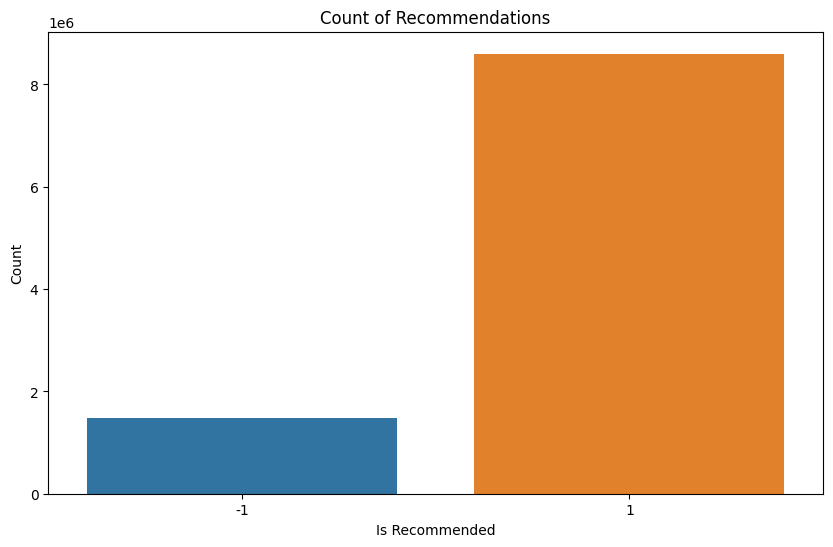

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Display the first few rows of the dataset
print(df.head())

# Get some basic information about the dataset
print(df.info())
print(df.describe())

# Visualize the count of recommendations
plt.figure(figsize=(10, 6))
sns.countplot(x="is_recommended", data=df)
plt.xlabel("Is Recommended")
plt.ylabel("Count")
plt.title("Count of Recommendations")
plt.show()

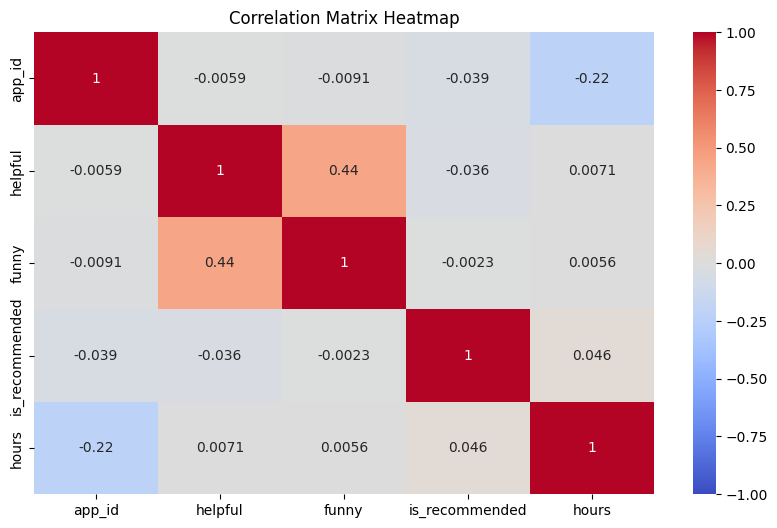

In [ ]:
# Calculate the correlation matrix for numeric features
numeric_features = ["app_id", "helpful", "funny", "is_recommended", "hours"]
correlation_matrix = df[numeric_features].corr()

# Visualize the correlation matrix as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Multiply
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

'user_id', 'app_id', 'is_recommended'

# Split the data into features (X) and target (y)
# Replace 'user_ids', 'item_ids', and 'ratings' with the appropriate column names from your dataset
user_ids = df_clean['user_id']
item_ids = df_clean['app_id']
ratings = df_clean['is_recommended']

# Split the data into training and testing sets (80% for training, 20% for testing)
train_user_ids, test_user_ids, train_item_ids, test_item_ids, train_ratings, test_ratings = train_test_split(
    user_ids, item_ids, ratings, test_size=0.2, random_state=42)

# NeuMF hyperparameters
num_users = max(user_ids) + 1
num_items = max(item_ids) + 1
mf_dim = 64
mlp_layer_sizes = [64, 32, 16, 8]
mlp_layer_regs = [0, 0, 0, 0]
num_epochs = 3
batch_size = 256
learning_rate = 0.01

# NeuMF model definition
# Matrix factorization part
user_input = Input(shape=(1,), dtype='int32', name='user_input')
item_input = Input(shape=(1,), dtype='int32', name='item_input')

mf_user_embedding = Embedding(input_dim=num_users, output_dim=mf_dim, input_length=1)(user_input)
mf_item_embedding = Embedding(input_dim=num_items, output_dim=mf_dim, input_length=1)(item_input)
mf_user_vecs = Flatten()(mf_user_embedding)
mf_item_vecs = Flatten()(mf_item_embedding)
mf_vec = Multiply()([mf_user_vecs, mf_item_vecs])

# MLP part
mlp_user_embedding = Embedding(input_dim=num_users, output_dim=mlp_layer_sizes[0] // 2, input_length=1)(user_input)
mlp_item_embedding = Embedding(input_dim=num_items, output_dim=mlp_layer_sizes[0] // 2, input_length=1)(item_input)
mlp_user_vecs = Flatten()(mlp_user_embedding)
mlp_item_vecs = Flatten()(mlp_item_embedding)
mlp_vec = Concatenate()([mlp_user_vecs, mlp_item_vecs])

for idx, layer_size in enumerate(mlp_layer_sizes[1:]):
    mlp_vec = Dense(layer_size, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(mlp_layer_regs[idx]))(mlp_vec)

# Combine MF and MLP parts
predict_vector = Concatenate()([mf_vec, mlp_vec])
output = Dense(1, activation='sigmoid')(predict_vector)

model = Model(inputs=[user_input, item_input], outputs=output)

# Compile and train the model
model.compile(optimizer=Adam(lr=learning_rate), loss='mean_squared_error')
model.fit([train_user_ids, train_item_ids], train_ratings, batch_size=batch_size, epochs=num_epochs, validation_split=0.1)


Epoch 1/3
28329/28329 [==============================] - 4612s 162ms/step - loss: 0.4446 - val_loss: 0.4354
Epoch 2/3
28329/28329 [==============================] - 4586s 162ms/step - loss: 0.1816 - val_loss: 0.5225
Epoch 3/3
28329/28329 [==============================] - 4587s 162ms/step - loss: 0.1486 - val_loss: 0.5143


In [ ]:
kf = KFold(n_splits=5)  # You can choose the number of folds (e.g., 5)

rmse_scores = []

for train_index, val_index in kf.split(X):
    X_train_cv, X_val_cv = X[train_index], X[val_index]
    y_train_cv, y_val_cv = y[train_index], y[val_index]

    # Create the NeuMF model
    model = create_neumf_model(num_users, num_items, mf_dim, layers)

    # Compile the model
    model.compile(optimizer=Adam(lr=0.001), loss='mse', metrics=['mse'])

    # Train the model
    model.fit([X_train_cv[:, 0], X_train_cv[:, 1]], y_train_cv, epochs=epochs, batch_size=batch_size, verbose=0)

    # Evaluate the model
    mse_score = model.evaluate([X_val_cv[:, 0], X_val_cv[:, 1]], y_val_cv, batch_size=batch_size, verbose=0)[1]
    rmse_scores.append(np.sqrt(mse_score))

# Calculate the average RMSE score
mean_rmse = np.mean(rmse_scores)
print(f'Mean RMSE score across all folds: {mean_rmse}')


NameError: ignored

In [ ]:
import matplotlib.pyplot as plt

# Train the model and store training history
history = model.fit(
    [train_user_ids, train_item_ids],
    train_ratings,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.1,
)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
import numpy as np

# Evaluate the model on test data
test_loss = model.evaluate([test_user_ids, test_item_ids], test_ratings)

# Add test loss to history
num_epochs = len(history.history['loss'])
history.history['test_loss'] = np.full(num_epochs, test_loss)

# Plot training, validation, and test loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.plot(history.history['test_loss'], label='Test loss', linestyle='--')
plt.title('Training, Validation, and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Predict ratings for test data
predicted_ratings = model.predict([test_user_ids, test_item_ids])

# Calculate evaluation metrics
mse = mean_squared_error(test_ratings, predicted_ratings)
mae = mean_absolute_error(test_ratings, predicted_ratings)
rmse = np.sqrt(mse)

# Display evaluation metrics
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")

# Plot evaluation metrics
metrics = ['MSE', 'MAE', 'RMSE']
values = [mse, mae, rmse]

plt.bar(metrics, values)
plt.title('Evaluation Metrics')
plt.ylabel('Value')
plt.show()
